## INP concentrations
Trying to plot INP concentration against isotherm to compare with measurements in Tobo et al. 2019

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(model_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(mods_dir)

all_cases

['20200131_120822_singleparam_nimaxmod_wbf_1_inp_1',
 '20200109_nfclimo_f19tn14',
 '20200128_162401_singleparam_altINPm1_wbf_1_inp_100',
 '20200128_142110_singleparam_frzrtvarsm1_wbf_1_inp_1',
 '20200131_120716_singleparam_nimaxmod_wbf_1_inp_100',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_1',
 '20200128_162401_singleparam_altINPm1_wbf_1_inp_1']

In [4]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

all_cases

['20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 'paramspace.png',
 '20191122_161009_sampleparamset_wbf_1_inp_1']

### Divide cases by modification and duration

In [5]:
cases = ['20200109_1541_wbf_1.0_inp_1.0', 
        '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1', 
        '20200112_002538_singleparam_nudge_wbf_1_inp_0', 
        '20200110_142006_singleparam_nudge_wbf_1_inp_1000', 
        '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

cases = ['20200128_142110_singleparam_frzrtvarsm1_wbf_1_inp_1']

cases = ['20200128_162401_singleparam_altINPm1_wbf_1_inp_1',
         '20200128_162401_singleparam_altINPm1_wbf_1_inp_100',
#         '20200128_142110_singleparam_frzrtvarsm1_wbf_1_inp_1',
#         '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_1',
         '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100']

month15cases = ['20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
                '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_1']

nomax = ['20200128_162401_singleparam_altINPm1_wbf_1_inp_1',
         '20200131_120822_singleparam_nimaxmod_wbf_1_inp_1',
         '20200131_120716_singleparam_nimaxmod_wbf_1_inp_100']

standardcases = ['20200109_1541_wbf_1.0_inp_1.0',
                 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
                 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
                 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
                 '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

Add INP sum variable, then mask non-Arctic latitudes and weight by cell area to produce concentration vs. temperature relation.

In [8]:
variables = ['AREI','FREQI','NUMICE','NUMICE10s','DSTFREZIMM', 'DSTFREZCNT', 'DSTFREZDEP','NNUCCTO', 'NNUCCCO', 'NNUDEPO', 'NIHOMOO','HOMOO','NIMIX_CNT','NIMIX_IMM','RELHUM','T','RHO_CLUBB']

# Go through cases and only open the first month

In [11]:
xr.set_options(keep_attrs=True)  # keeps variable names and units

# Load NorESM data
processed = []
names = []
for i in cases:
    ds = xr.open_mfdataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, i, i), combine='by_coords')
    _nm = ' '.join(i.split('_')[-5:])
    
    if (len(ds['time']) > 1):
        try:
            ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
        except:
            ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
    ds = add_weights(ds) # still has time here
    
    ds['NUMICE10s_kg'] = ds['NUMICE10s']/ds['RHO_CLUBB']
    variables.append('NUMICE10s_kg')
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
    weight = ds['cell_weight']
    processed.append(masked_average(ds[variables], dim=['lat','lon','ilev'],weights=weight, mask=mask))
    names.append(_nm)

### Open 15-month cases and select the last year

In [8]:
xr.set_options(keep_attrs=True)  # keeps variable names and units

# Load NorESM data
processed15m = []
names15m = []
for i in month15cases:
    ds = xr.open_mfdataset('%s/%s/%s.nc' % (mods_dir, i, i), combine='by_coords')
    _nm = ' '.join(i.split('_')[-5:])
    
    if (len(ds['time']) > 1):
        try:
            ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
        except:
            ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
    ds = add_weights(ds) # still has time here

    ds['NUMICE10s_kg'] = ds['NUMICE10s']/ds['RHO_CLUBB']
    variables.append('NUMICE10s_kg')
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
    weight = ds['cell_weight']
    processed15m.append(masked_average(ds[variables], dim=['lat','lon', 'ilev'],weights=weight, mask=mask))
    names15m.append(_nm)

### Cases where the nimax limit has been removed

In [6]:
# Load NorESM data
xr.set_options(keep_attrs=True)  # keeps variable names and units

processednomax = []
namesnomax = []
for i in nomax:
    ds = xr.open_mfdataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, i, i), combine='by_coords')
    _nm = ' '.join(i.split('_')[-5:])
    
    if (len(ds['time']) > 1):
        try:
            ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
        except:
            ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
    ds = add_weights(ds) # still has time here
    
    ds['NUMICE10s_kg'] = ds['NUMICE10s']/ds['RHO_CLUBB']
    variables.append('NUMICE10s_kg')
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
    weight = ds['cell_weight']
    processednomax.append(masked_average(ds[variables], dim=['lat','lon','ilev'],weights=weight, mask=mask))
    namesnomax.append(_nm)

### The standard cases

In [ ]:
xr.set_options(keep_attrs=True)  # keeps variable names and units
limited_variables = ['AREI','FREQI','NUMICE','NUMICE10s','DSTFREZIMM', 'DSTFREZCNT', 'DSTFREZDEP','RELHUM','T','RHO_CLUBB']
# Load NorESM data
processedstd = []
namesstd = []
for i in standardcases:
    ds = xr.open_mfdataset('%s/%s/%s.nc' % (case_dir, i, i), combine='by_coords')
    _nm = ' '.join(i.split('_')[-5:])
    
    if (len(ds['time']) > 1):
        try:
            ds = ds.sel(time=slice('0001-04-01', '0002-03-01'))
        except:
            ds = ds.sel(time=slice('2000-04-01', '2001-03-01'))
    ds = add_weights(ds) # still has time here

    ds['NUMICE10s_kg'] = ds['NUMICE10s']/ds['RHO_CLUBB']
    limited_variables.append('NUMICE10s_kg')
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask= np.bitwise_or(ds['lat']<70, ds['lat']>90)
    weight = ds['cell_weight']
    processedstd.append(masked_average(ds[limited_variables], dim=['lat','lon', 'ilev','time'],weights=weight, mask=mask))
    namesstd.append(_nm)

Plot Stuff

### First set of plots:
frzrtvarsm15 is a 15-month run with nudged uvp and INP increased by 100x within the Hoose Scheme. It has the new heterogeneous freezing rate variables added through user_nl_cam.

Variables with descriptions:

'NIMIX_CNT': Activated Ice Number Concentration due to het contact freezing in Mixed Clouds  
'NIMIX_IMM': Activated Ice Number Concentration due to het immersion freezing in Mixed Clouds  
'NIMIX_DEP': Activated Ice Number Concentration due to het deposition freezing in Mixed Clouds  
'NNUCCTO': 'NC tendency contact freezing' (1/kg/s)  
'NNUCCCO': 'NC tendency immersion freezing' (1/kg/s)  
'NNUDEPO': 'NI deposition' (1/kg/s)  
'NIHOMOO': 'NI tendency homogeneous freezing' (1/kg/s)  
'HOMOO': homogeneous freezing of cloud water (kg/kg/s)   
'NHOMOO': 'NI tendency homogeneous freezing' (1/kg/s)  
'DSTFREZIMM': dust immersion freezing rate (m-3s-1)  
'DSTFREZCNT': dust contact freezing rate (m-3s-1)  
'DSTFREZDEP': dust depsotion freezing rate (m-3s-1)  
'NUMICE': Grid box averaged cloud ice number (1/kg)  
'NUMICE10s': Ice Number Concentration due to het freezing in Mixed Clouds during 10-s period (#/m3)  

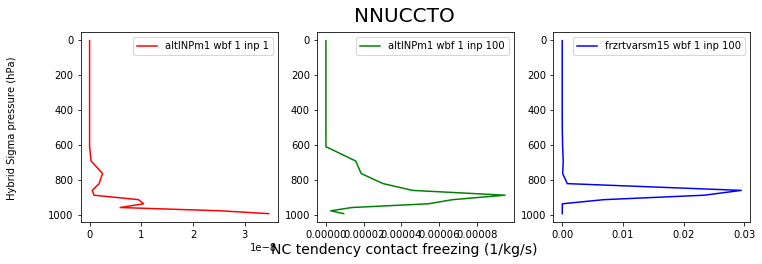

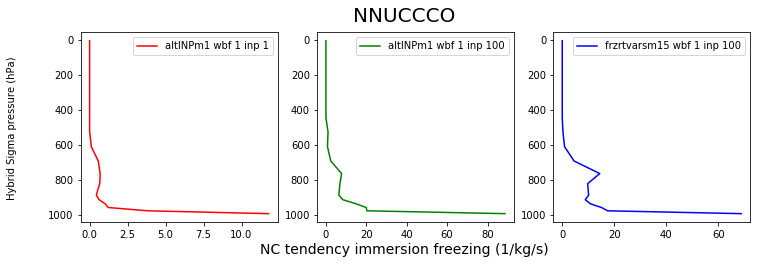

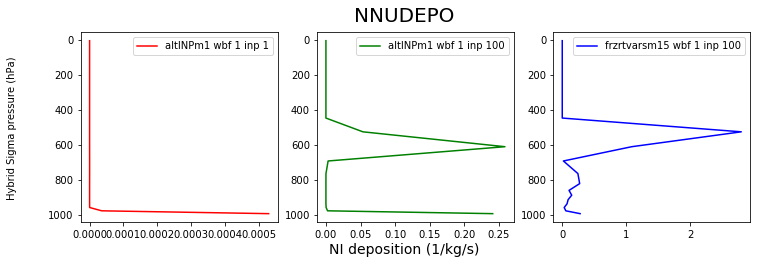

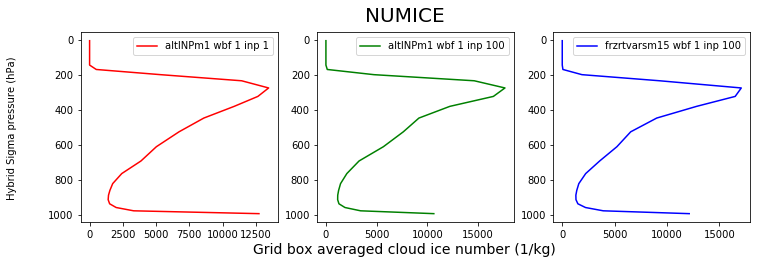

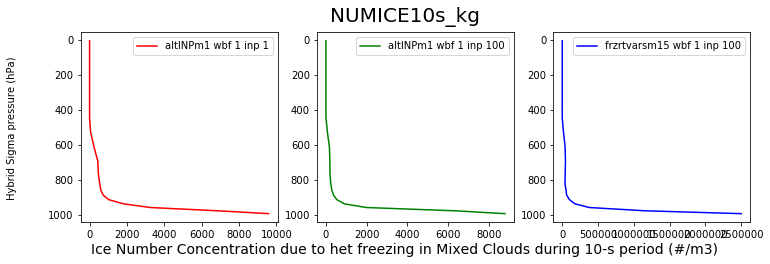

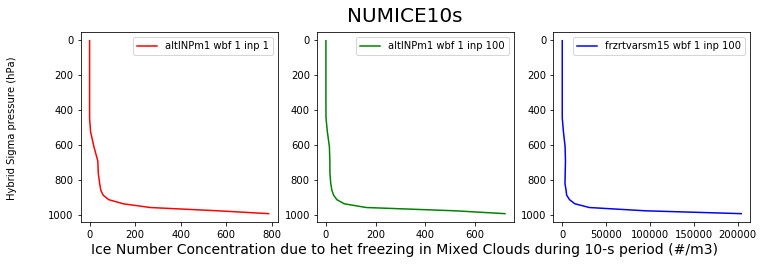

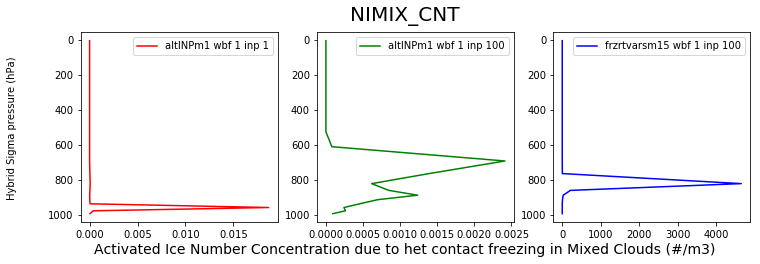

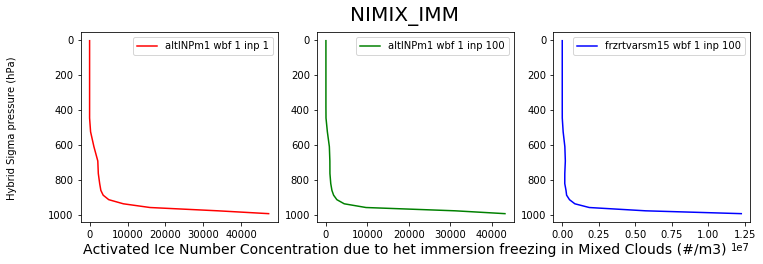

In [12]:
hetprocesses = ['NNUCCTO','NNUCCCO','NNUDEPO','NUMICE','NUMICE10s_kg','NUMICE10s','NIMIX_CNT','NIMIX_IMM']#,'NIMIX_DEP']
colors = ['r','g','b']

for types in hetprocesses:
    _fig = plt.figure(figsize=(12,3.5))#constrained_layout=True)
    _spec = gridspec.GridSpec(ncols=3, nrows=1, figure=_fig)#, hspace=0.4)
    f1_ax1 = _fig.add_subplot(_spec[0, 0])
    f1_ax2 = _fig.add_subplot(_spec[0, 1], sharey=f1_ax1)
    f1_ax3 = _fig.add_subplot(_spec[0, -1], sharey=f1_ax1)
    axes = [f1_ax1, f1_ax2, f1_ax3]
    plt.gca().invert_yaxis()
    _fig.suptitle(types, fontsize=20)

    xaxis_label = '%s (%s)' % (processed[0][types].long_name, processed[0][types].units)    
    _fig.text(0.5, 0.0, xaxis_label, ha='center', fontsize=14)
    _fig.text(0.04, 0.5, 'Hybrid Sigma pressure (hPa)', va='center', rotation='vertical')
    
    for ax, name, color, data in zip(axes, names, colors, processed):
        ax.plot(data[types][0], data[types][0]['lev'], label=name, color=color)
        ax.legend()

### Plot original freezing tendencies and the enhancement ratios with 100x INP

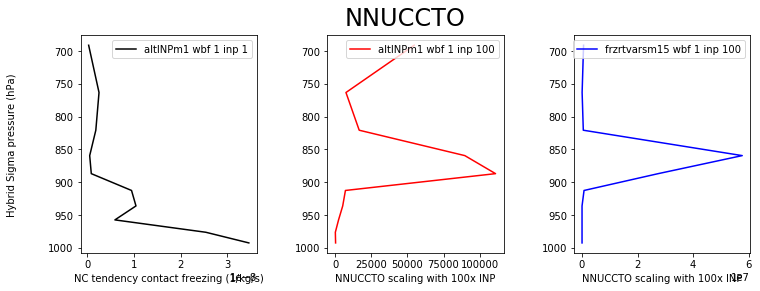

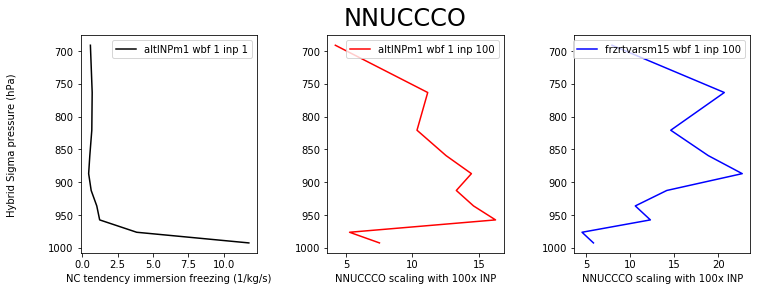

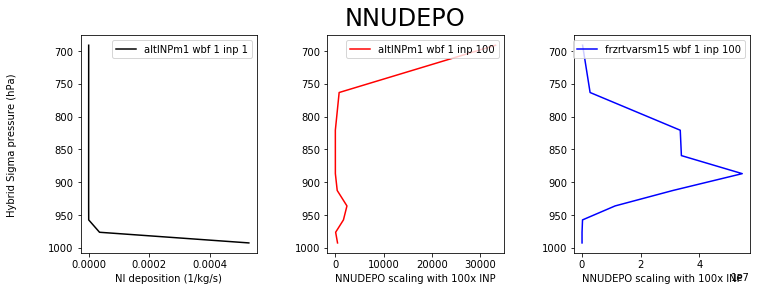

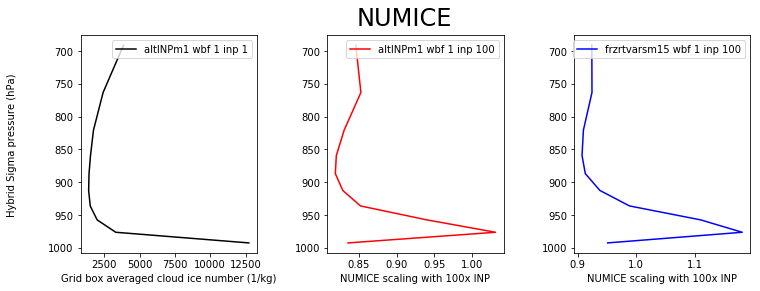

In [9]:
hetprocesses = ['NNUCCTO','NNUCCCO','NNUDEPO','NUMICE']
colors = ['red','blue','black']
for types in hetprocesses:
    _fig = plt.figure(figsize=(12,4))#constrained_layout=True)
    _spec = gridspec.GridSpec(ncols=3, nrows=1, figure=_fig, wspace=0.4)
    f1_ax1 = _fig.add_subplot(_spec[0, 0])
    f1_ax2 = _fig.add_subplot(_spec[0, 1], sharey=f1_ax1)
    f1_ax3 = _fig.add_subplot(_spec[0, -1], sharey=f1_ax1)
    axes = [f1_ax2, f1_ax3]
    plt.gca().invert_yaxis()
    _fig.suptitle(types, fontsize=24)
    xaxis_label = '%s (%s)' % (processed[0][types].long_name, processed[0][types].units)    
    _fig.text(0.04, 0.5, 'Hybrid Sigma pressure (hPa)', va='center', rotation='vertical')
    f1_ax1.plot(processed[2][types][0,-10:], processed[2]['lev'][-10:], label=names[2], color=colors[-1])
    f1_ax1.set_xlabel(xaxis_label)
    f1_ax1.legend(loc='upper right')
    
    for ax, data, name, color in zip(axes, processed, names, colors):
        ax.set_xlabel('%s scaling with 100x INP' % types)
        ax.plot((data[types][0,-10:])/(processed[2][types][0,-10:]), data['lev'][-10:], label=name, color=color)
        ax.legend(loc='upper right')        


### Verify that the INP multiplier in micro_mg2 causes no unwanted effects

In [181]:
cc = '20200109_nfclimo_f19tn14'
controlcontrol = xr.open_dataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, cc, cc))

c = '20200128_162401_singleparam_altINPm1_wbf_1_inp_1'
control = xr.open_dataset('%s/%s/atm/hist/%s.cam.h0.2000-01.nc' % (mods_dir, c, c))


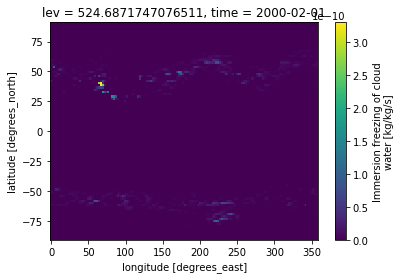

In [196]:
controlcontrol['MNUCCCO'][0,20,:,:].plot()

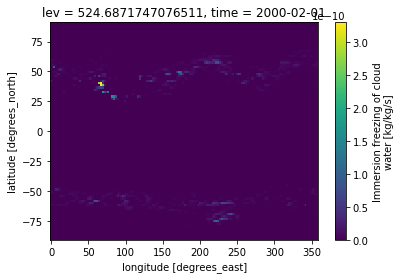

In [194]:
control['MNUCCCO'][0,20,:,:].plot()

### Ice Variables with nimax limit removed

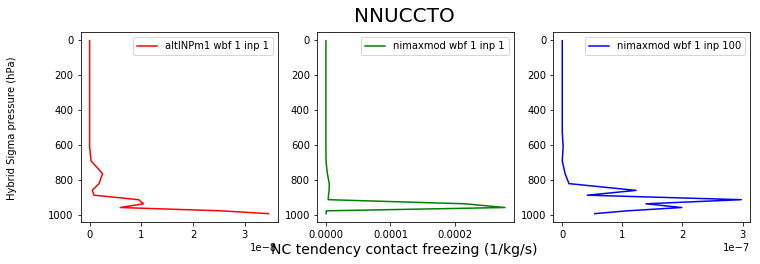

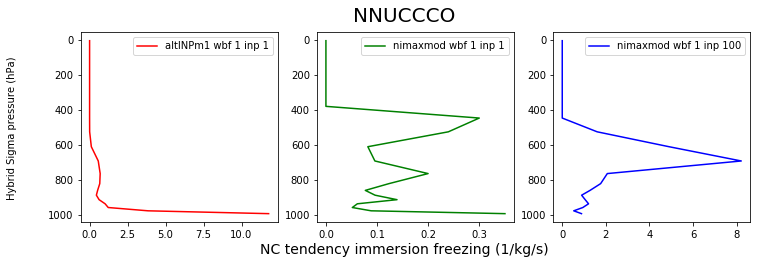

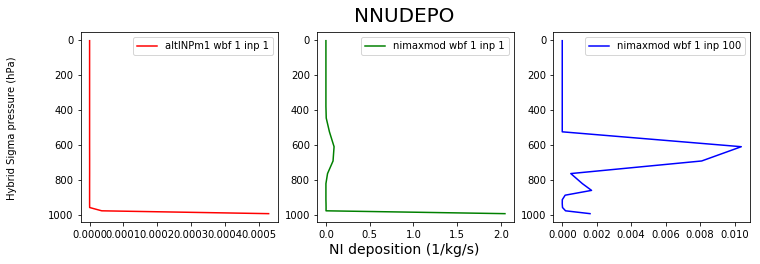

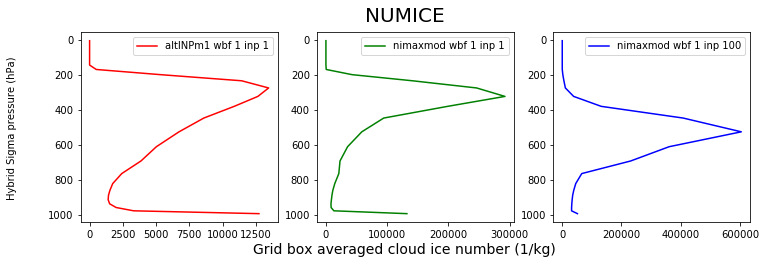

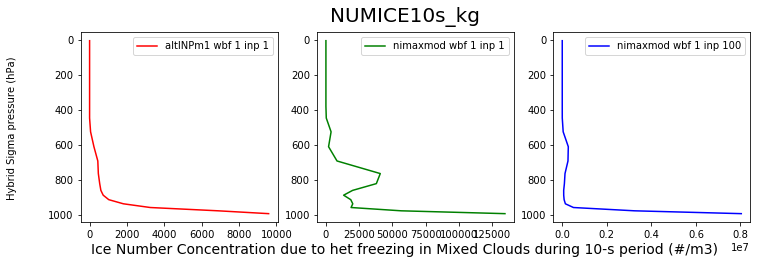

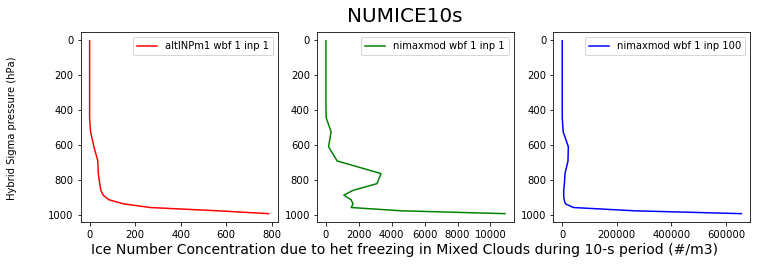

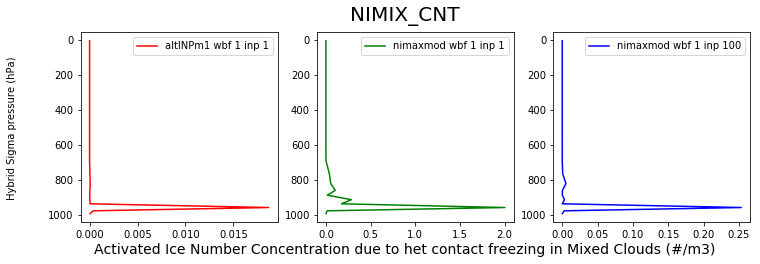

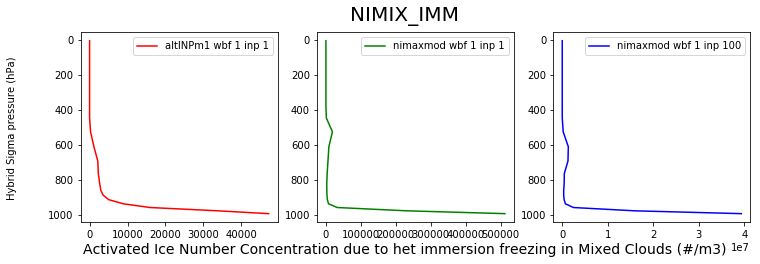

In [7]:
hetprocesses = ['NNUCCTO','NNUCCCO','NNUDEPO','NUMICE','NUMICE10s_kg','NUMICE10s','NIMIX_CNT','NIMIX_IMM']#,'NIMIX_DEP']
colors = ['r','g','b']

for types in hetprocesses:
    _fig = plt.figure(figsize=(12,3.5))#constrained_layout=True)
    _spec = gridspec.GridSpec(ncols=3, nrows=1, figure=_fig)#, hspace=0.4)
    f1_ax1 = _fig.add_subplot(_spec[0, 0])
    f1_ax2 = _fig.add_subplot(_spec[0, 1], sharey=f1_ax1)
    f1_ax3 = _fig.add_subplot(_spec[0, -1], sharey=f1_ax1)
    axes = [f1_ax1, f1_ax2, f1_ax3]
    plt.gca().invert_yaxis()
    _fig.suptitle(types, fontsize=20)

    xaxis_label = '%s (%s)' % (processednomax[0][types].long_name, processednomax[0][types].units)    
    _fig.text(0.5, 0.0, xaxis_label, ha='center', fontsize=14)
    _fig.text(0.04, 0.5, 'Hybrid Sigma pressure (hPa)', va='center', rotation='vertical')
    
    for ax, name, color, data in zip(axes, namesnomax, colors, processednomax):
        ax.plot(data[types][0], data[types][0]['lev'], label=name, color=color)
        ax.legend()

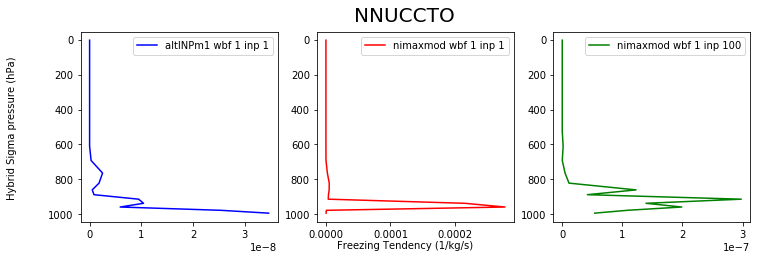

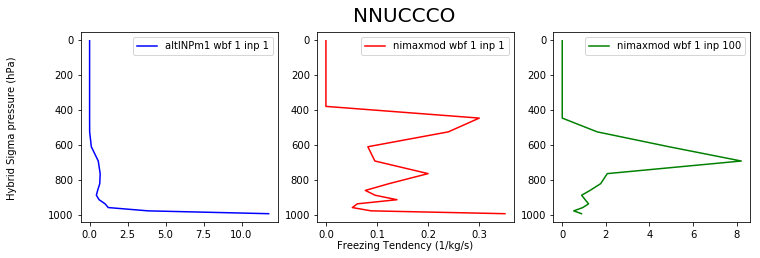

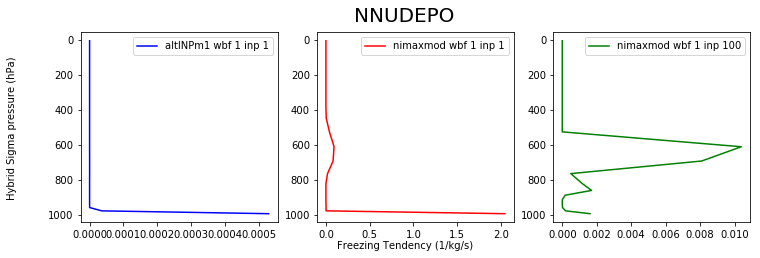

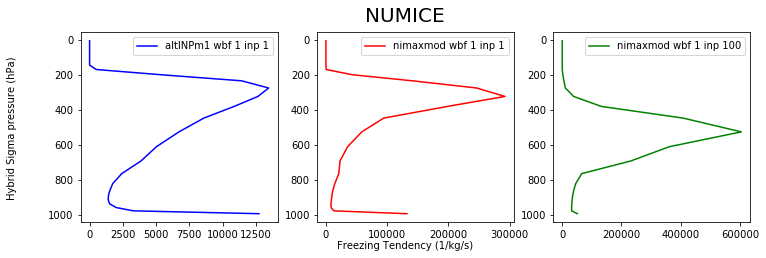

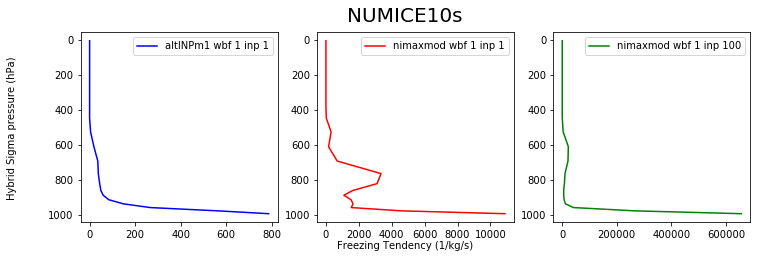

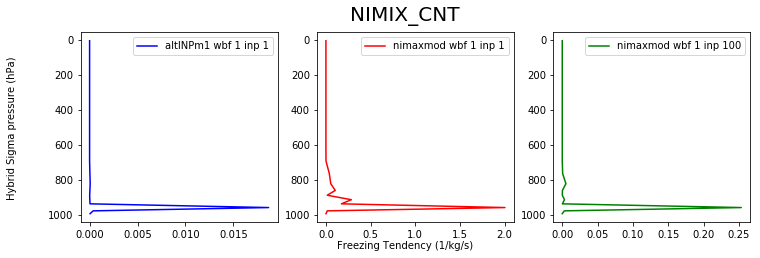

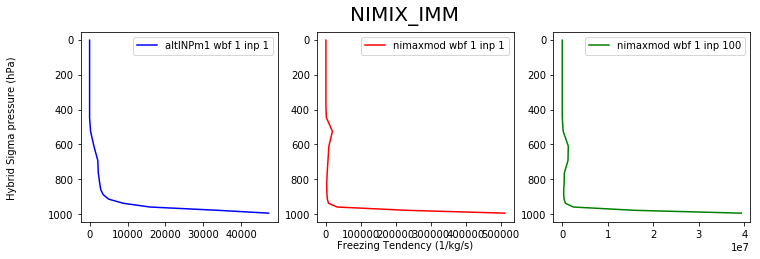

In [12]:
hetprocesses = ['NNUCCTO','NNUCCCO','NNUDEPO','NUMICE','NUMICE10s','NIMIX_CNT','NIMIX_IMM']

for types in hetprocesses:
    _fig = plt.figure(figsize=(12,3.5))#constrained_layout=True)
    _spec = gridspec.GridSpec(ncols=3, nrows=1, figure=_fig)#, hspace=0.4)
    f1_ax1 = _fig.add_subplot(_spec[0, 0])
    f1_ax2 = _fig.add_subplot(_spec[0, 1], sharey=f1_ax1)
    f1_ax3 = _fig.add_subplot(_spec[0, -1], sharey=f1_ax1)
    axes = [f1_ax1, f1_ax2]
    plt.gca().invert_yaxis()
    _fig.suptitle(types, fontsize=20)
#    f1_ax1.xlabel('Freezing Tendency (1/kg/s)'); f1_ax1.ylabel('Hybrid Sigma pressure (hPa)');
#    _fig.xlabel('Freezing Tendency (1/kg/s)'); _fig.ylabel('Hybrid Sigma pressure (hPa)');
   # for (rad, nm) in zip(processed, names):
    _fig.text(0.5, 0.02, 'Freezing Tendency (1/kg/s)', ha='center')
    _fig.text(0.04, 0.5, 'Hybrid Sigma pressure (hPa)', va='center', rotation='vertical')
    f1_ax1.plot(processednomax[0][types][0], processednomax[0]['lev'], label=namesnomax[0], color='b')
    f1_ax2.plot(processednomax[1][types][0], processednomax[0]['lev'], label=namesnomax[1], color='r')
    f1_ax3.plot(processednomax[2][types][0], processednomax[0]['lev'], label=namesnomax[2], color='g')
    f1_ax1.legend()        
    f1_ax2.legend()
    f1_ax3.legend()    

### Plotting limited available variables for the 'Standard' Runs

In [ ]:
limited_variables = ['AREI','FREQI','NUMICE','NUMICE10s_kg', 'NUMICE10s','DSTFREZIMM', 'DSTFREZCNT', 'DSTFREZDEP']
colors = ['r','g','b']
axes=[]

for var in limited_variables:
    _fig = plt.figure(figsize=(12,3.5))#constrained_layout=True)
    _spec = gridspec.GridSpec(ncols=len(processedstd), nrows=1, figure=_fig)#, hspace=0.4)
    for i, run in enumerate(processedstd):
        if i==0:
            _ax = _fig.add_subplot(_spec[0,i])
        else: 
            _ax = _fig.add_subplot(_spec[0,i], sharey=axes[0])
        axes.append(_ax)
            
    plt.gca().invert_yaxis()
    _fig.suptitle(var, fontsize=20)

#    xaxis_label = '%s (%s)' % (processedstd[0][var].long_name, processedstd[0][var].units)    
    xaxis_label = '%s (%s)' % (processedstd[0][var].long_name, processedstd[0][var].units)    
    _fig.text(0.5, 0.0, xaxis_label, ha='center', fontsize=14)
    _fig.text(0.04, 0.5, 'Hybrid Sigma pressure (hPa)', va='center', rotation='vertical')
    
    for ax, name, color, data in zip(axes, namesstd, colors, processedstd):
        ax.plot(data[var][0], data[var][0]['lev'], label=name, color=color)
        ax.legend()

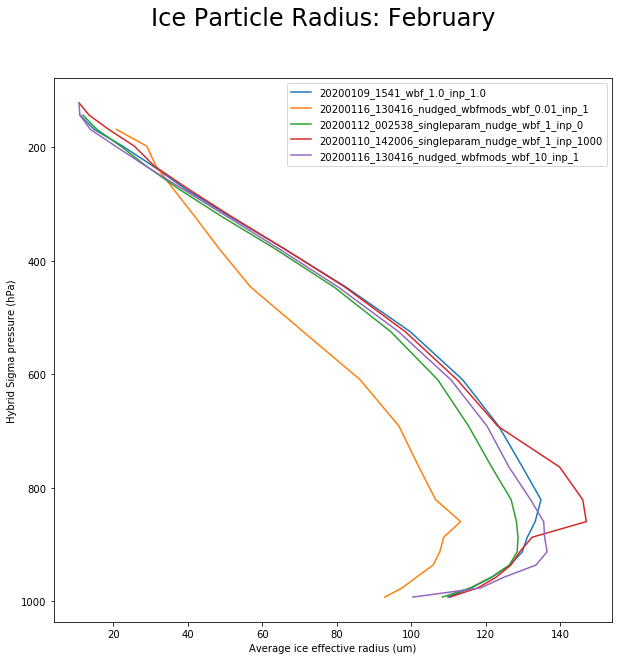

In [45]:
feb_plot = plt.figure(figsize=[10,10])

feb_plot.gca().invert_yaxis()
for (rad, nm) in zip(processed, names):
    plt.plot(rad[1], rad[1]['lev'], label=nm)
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
feb_plot.suptitle('Ice Particle Radius: February', fontsize=24)
plt.xlabel('Average ice effective radius (um)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

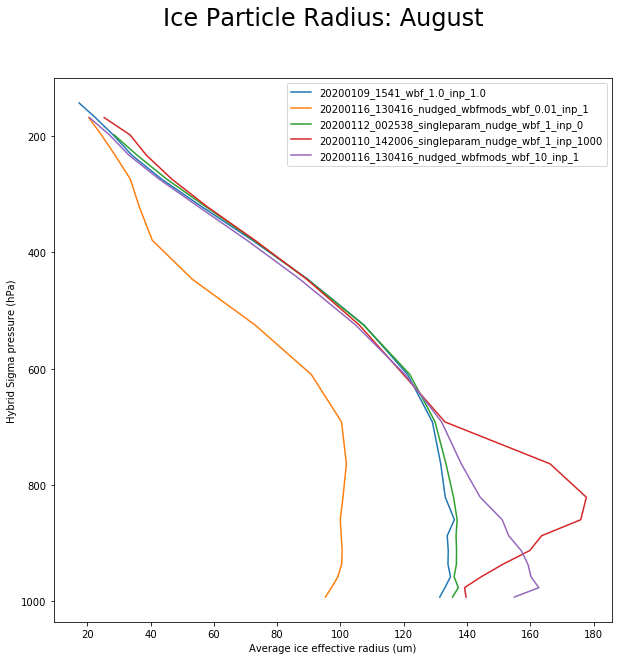

In [47]:
aug_plot = plt.figure(figsize=[10,10])

aug_plot.gca().invert_yaxis()
for (rad, nm) in zip(processed, names):
    plt.plot(rad[7], rad[7]['lev'], label=nm)
    
plt.legend(loc='upper right')
aug_plot.suptitle('Ice Particle Radius: August', fontsize=24)
plt.xlabel('Average ice effective radius (um)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

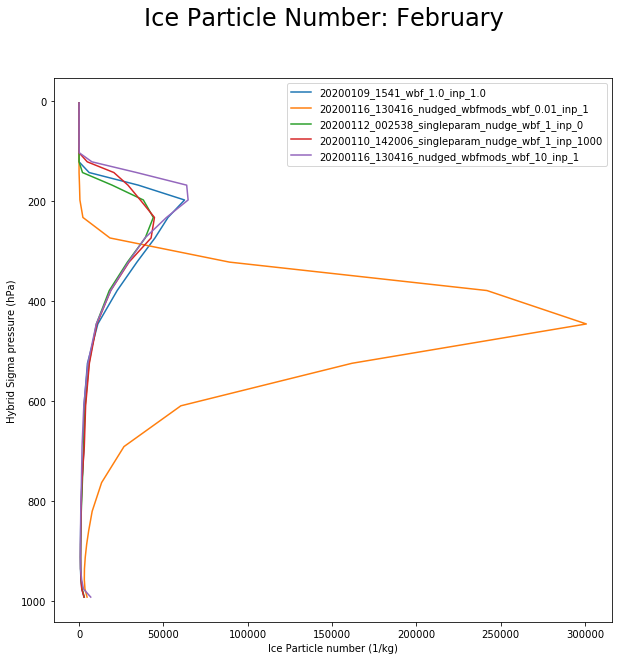

In [46]:
feb_plot = plt.figure(figsize=[10,10])

feb_plot.gca().invert_yaxis()
for (rad, nm) in zip(numice, names):
    plt.plot(rad[1], rad[1]['lev'], label=nm)
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
feb_plot.suptitle('Ice Particle Number: February', fontsize=24)
plt.xlabel('Ice Particle number (1/kg)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

# WHY?

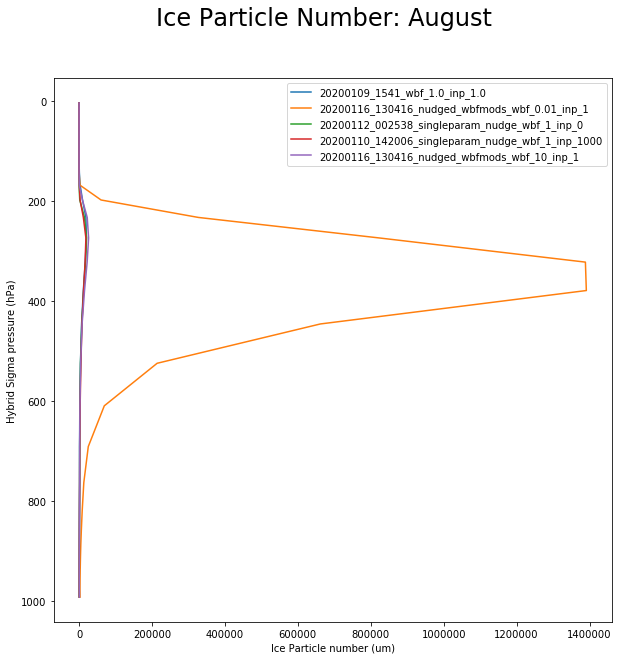

In [29]:
feb_plot = plt.figure(figsize=[10,10])

feb_plot.gca().invert_yaxis()
for (rad, nm) in zip(numice, names):
    plt.plot(rad[7], rad[7]['lev'], label=nm)
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
feb_plot.suptitle('Ice Particle Number: August', fontsize=24)
plt.xlabel('Ice Particle number (1/kg)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

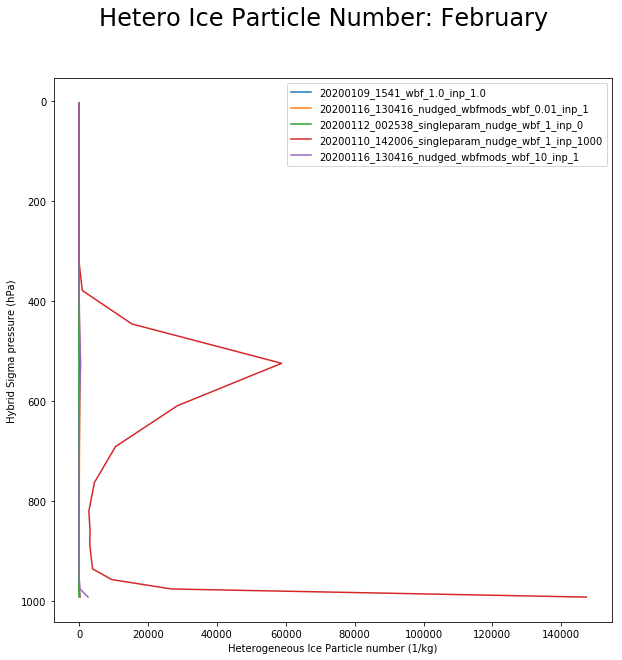

In [36]:
feb_plot = plt.figure(figsize=[10,10])

feb_plot.gca().invert_yaxis()
for (rad, nm) in zip(numice10s, names):
    plt.plot(rad[1], rad[1]['lev'], label=nm)
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
feb_plot.suptitle('Hetero Ice Particle Number: February', fontsize=24)
plt.xlabel('Heterogeneous Ice Particle number (1/kg)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

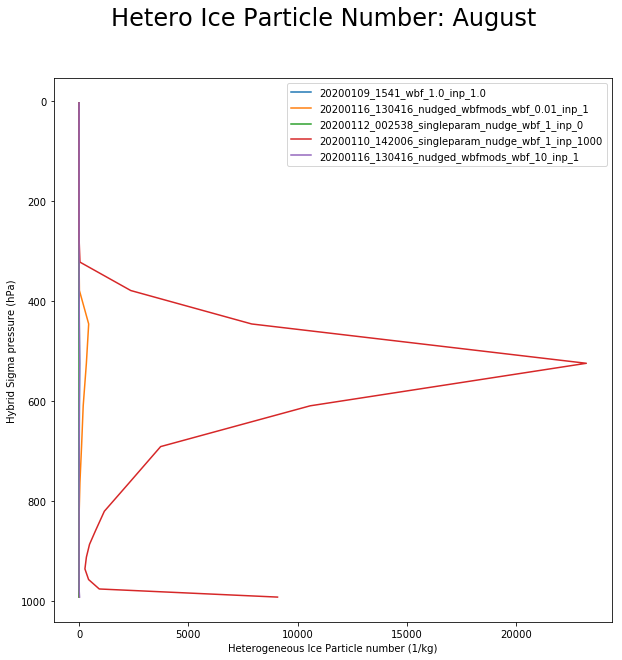

In [35]:
feb_plot = plt.figure(figsize=[10,10])

feb_plot.gca().invert_yaxis()
for (rad, nm) in zip(numice10s, names):
    plt.plot(rad[7], rad[7]['lev'], label=nm)
    
#feb_plot.legend(loc='upper right')
plt.legend(loc='upper right')
feb_plot.suptitle('Hetero Ice Particle Number: August', fontsize=24)
plt.xlabel('Heterogeneous Ice Particle number (1/kg)'); plt.ylabel('Hybrid Sigma pressure (hPa)');

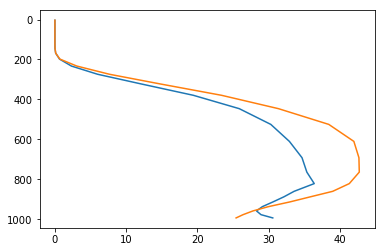

In [11]:
plt.plot(ice_radius[1], ice_radius[1]['lev'])
plt.plot(ice_radius[7], ice_radius[7]['lev'])

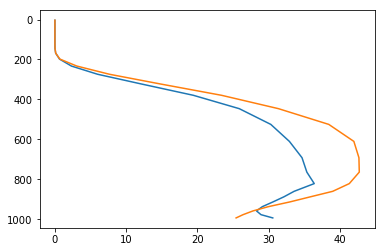

In [11]:
plt.gca().invert_yaxis()
plt.plot(ice_radius[1], ice_radius[1]['lev'])
plt.plot(ice_radius[7], ice_radius[7]['lev'])

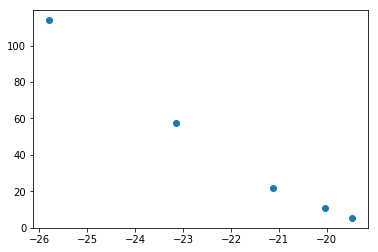

In [56]:
plt.scatter(tt[27:]-273.15, inp[27:]/1000)

Text(0,0.5,'INP concentration ($l{^-1}$)')

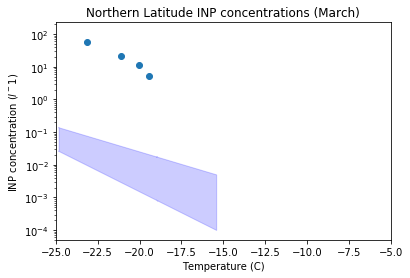

In [57]:
plt.fill_between(inpobs['T'], y1=lower_fit(inpobs['T']), y2=upper_fit(inpobs['T']),alpha=0.2, color='blue', label='Range from observations in Tobo et al., 2019')
#plt.scatter(inpobs['T'], inpobs['INP'])
plt.scatter(tt[27:]-273.15, inp[27:]/1000)
plt.yscale('log')
plt.xlim((-25,-5)); #plt.ylim((1e-4,1))
plt.title('Northern Latitude INP concentrations (March)')
plt.xlabel('Temperature (C)'); plt.ylabel('INP concentration ($l{^-1}$)')

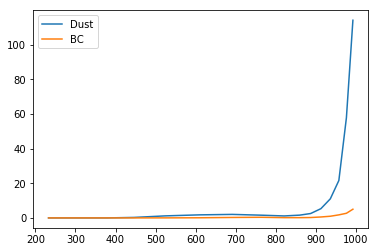

In [49]:
plt.plot(inp[15:]['lev'], inp[15:]/1000, label='Dust')
plt.plot(BCinp[15:]['lev'], BCinp[15:]/1000, label='BC')
plt.legend()

In [44]:
ds['NIMIX_IMM']

<xarray.DataArray 'NIMIX_IMM' (time: 1, lev: 32, lat: 96, lon: 144)>
[442368 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 0001-04-01 00:00:00
Attributes:
    mdims:         1
    units:         #/m3
    long_name:     Activated Ice Number Concentration due to het immersion fr...
    cell_methods:  time: mean

Text(0.5,0.98,'20191230_130025_singleparam_cttest15_wbf_1_inp_1')

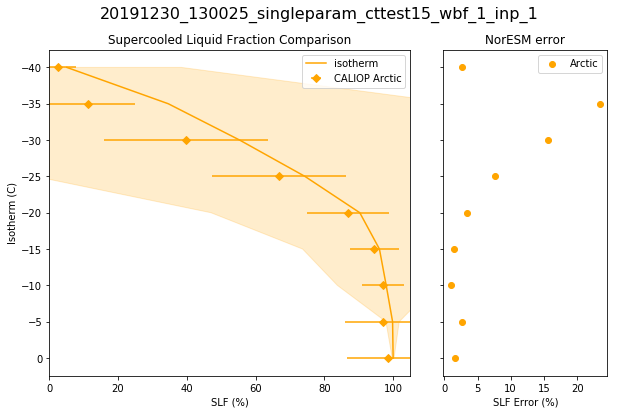

In [96]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)

fig1.gca().invert_yaxis()

colors = ['blue', 'orange', 'red']

for b,c in zip(bands, colors):
    if b == 'Arctic':
        f1_ax1.errorbar(df['CALIOP %s SLF' % b], df['isotherm'], xerr=2*df['CALIOP %s StDev' % b], label='CALIOP %s' % b, color = c, fmt='o', marker='D')
        f1_ax1.plot(df['NorESM %s SLF' % b], df['isotherm'], color = c) #, label=b)
        f1_ax1.fill_betweenx(df['isotherm'], df['NorESM %s SLF' % b] - 2*df['NorESM %s StDev' % b], df['NorESM %s SLF' % b] + 2*df['NorESM %s StDev' % b], alpha=0.2, color=c)

        slf_error = df['NorESM %s SLF' % b] - df['CALIOP %s SLF' % b]
        f1_ax2.scatter(slf_error, df['isotherm'], color=c, label=b)

#_r = regress_1d(isos, all_slf_clean[error])
#_s = _r.score(isos, all_slf_clean[error])
#f1_ax2.plot(_r.predict(isos), isos, color=color, label = ('$R^2 = %f$' % _s))

f1_ax1.set_xlim((0,105))
f1_ax1.legend()
f1_ax2.legend()

fig1.suptitle(case, fontsize=16)